# Remote Sensing II

## Advanced plotting methods

In the last session, we only plotted the satellite data of MSG itself. Unfortunately, we have to follow our instincts (and duty) as Geographers and add some spatial context to the plots so that the viewer knows what exactly she or he sees.

So lets start with the natural color composite of Greece. 

First, we load MSG data again and resample the scene to our area definition of Greece and its surroundings:

In [1]:
from satpy import Scene, MultiScene
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pyresample import geometry

In [ ]:
dateien = ["../data/W_XX-EUMETSAT-Darmstadt,VIS+IR+HRV+IMAGERY,MSG1+SEVIRI_C_EUMG_20060117084508.nc"]
files = {"seviri_l1b_nc" : dateien}

scn = Scene(filenames=files)
scn.load(["natural_color"])
scn.load(scn.all_dataset_names()[1:])

In [2]:
area_id = "Griechenland"
description = "Griechenland und Umgebung in Mercator-Projektion"
proj_id = "Griechenland"
proj_dict = {"proj": "merc", "lat_ts": 38, 'lon_0': 25}

width = 800    # width of the result domain in pixels
height = 800   # height of the result domain in pixels

llx = -10E5   # projection x coordinate of lower left corner of lower left pixel
lly =  27E5   # projection y coordinate of lower left corner of lower left pixel
urx =  10E5   # projection x coordinate of upper right corner of upper right pixel
ury =  47E5   # projection y coordinate of upper right corner of upper right pixel

area_extent = (llx,lly,urx,ury)
area_def_greece = geometry.AreaDefinition(area_id, proj_id, description, proj_dict, width, height, area_extent)

#local_scn = scn.resample(area_def_greece)

Now, we can plot the scene and add some coastlines and a lat/lon grid:

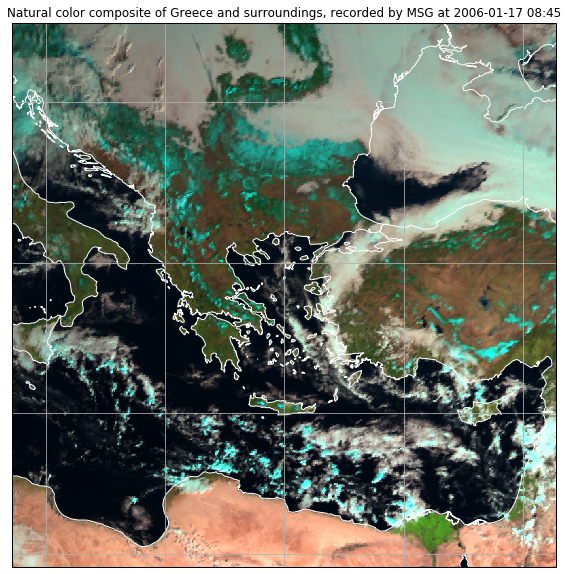

In [3]:
# First, we have to transpose the natural color composite values to a shape that can be interpreted 
# by the imshow method: (M,N,3)
image = np.asarray(local_scn["natural_color"]).transpose(1,2,0)

# Then we scale the values to the range between 0 and 1, clipping the lower and upper percentiles
# so that a potential contrast decrease caused by outliers is eliminated.
image = np.interp(image, (np.percentile(image,1), np.percentile(image,99)), (0, 1))

# Now we "copy" the coordinate reference system of our composite data set...
crs = local_scn["natural_color"].attrs["area"].to_cartopy_crs()

# ... and use it to generate an axes in our figure with the same CRS
fig = plt.subplots(figsize=(10,10))
ax = plt.axes(projection=crs)

# Now we can add some coastlines...
ax.coastlines(resolution="10m", color="white")

# ... and a lat/lon grid:
ax.gridlines(xlocs=range(10,45,5),ylocs=range(25,55,5))

# In the end, we can plot our image data...
ax.imshow(image, transform=crs, extent=crs.bounds, origin="upper")

# and add a title to our plot
plt.title("Natural color composite of Greece and surroundings, recorded by MSG at " + local_scn.attrs["start_time"].strftime("%Y-%m-%d %H:%M"))

# Finally, we can show the plot to the user:
plt.show()

If you want to add further shapes to the plot, you can do so by using the `feature` class of cartopy:

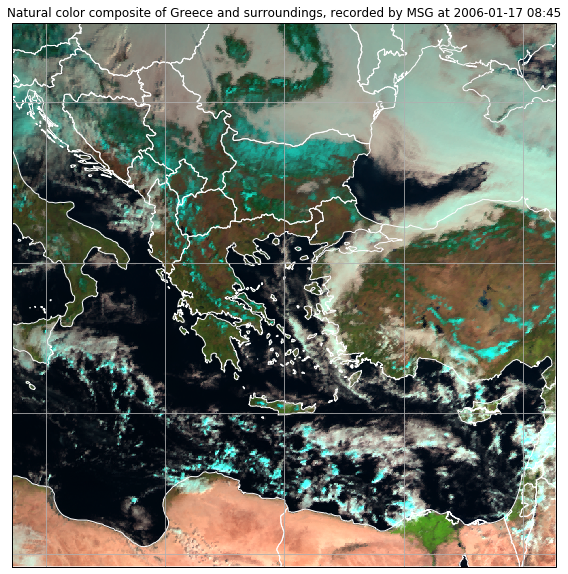

In [13]:
import cartopy.feature as cfeature

image = np.asarray(local_scn["natural_color"]).transpose(1,2,0)
image = np.interp(image, (np.percentile(image,1), np.percentile(image,99)), (0, 1))
crs = local_scn["natural_color"].attrs["area"].to_cartopy_crs()
fig = plt.subplots(figsize=(10,10))
ax = plt.axes(projection=crs)
ax.gridlines(xlocs=range(10,45,5),ylocs=range(25,55,5))

# ===================================================
states_provinces = cfeature.NaturalEarthFeature(
        category="cultural",
        name="admin_0_countries",
        scale="10m",
        facecolor="none")
ax.add_feature(states_provinces, edgecolor="white")
# ===================================================

ax.imshow(image, transform=crs, extent=crs.bounds, origin="upper")
plt.title("Natural color composite of Greece and surroundings, recorded by MSG at " + local_scn.attrs["start_time"].strftime("%Y-%m-%d %H:%M"))
plt.show()

##### **Task**

1. Download this MSG data set using our usual password: https://box.uni-marburg.de/index.php/s/bCu96BUfVyXtFCg
2. Resample the scene to Algeria and its surroundings using the Mercator projection. Use the following settings:
    - Latitude of true scale: 28
    - Longitude of projection center: 2
    - Domain size: 1000 x 1000
    - Area extent: [-13E5, 18E5, 12E5, 41E5]
3. Plot the resampled scene as natural color composite, add a grid and country borders as well as a title.

**Solution**

2. ```python
area_def_algeria = geometry.AreaDefinition("Algeria", "", "", 
                               {"proj": "merc", "lat_ts": 28, "lon_0": 2}, 
                               1000, 1000, 
                               (-13E5,18E5,12E5,41E5))
local_scn = scn.resample(area_def_algeria)
```

3. ```python
image = np.asarray(local_scn["natural_color"]).transpose(1,2,0)
image = np.interp(image, (np.percentile(image,1), np.percentile(image,99)), (0, 1))
crs = local_scn["natural_color"].attrs["area"].to_cartopy_crs()
fig = plt.subplots(figsize=(10,10))
ax = plt.axes(projection=crs)
ax.gridlines(xlocs=range(-15,30,5),ylocs=range(15,47,5))
states_provinces = cfeature.NaturalEarthFeature(
     category="cultural",
     name="admin_0_countries",
     scale="50m",
     facecolor="none")
ax.add_feature(states_provinces, edgecolor="white")
ax.imshow(image, transform=crs, extent=crs.bounds, origin="upper")
plt.title("Natural color composite of Algeria and surroundings, recorded by MSG at " + local_scn.attrs["start_time"].strftime("%Y-%m-%d %H:%M"))
plt.show()
```

## Working with multiple scenes (time series)

Often, we are interested not only in one specific scene but in the changes over consecutively recorded scenes.

For this purpose, we can make use of SatPy's (experimental) [MultiScene](https://satpy.readthedocs.io/en/latest/multiscene.html):

In [6]:
from satpy.multiscene import timeseries
from glob import glob

# Load all files in a given folder:
files = glob("../data/W_XX-EUMETSAT-Darmstadt,VIS+IR+HRV+IMAGERY,MSG1+SEVIRI_C_EUMG_*.nc")

# Create a MultiScene from the given list of scenes
scenes = [Scene(reader="seviri_l1b_nc", filenames=[f]) for f in files]
mscn = MultiScene(scenes)

# Load the 10.8 micrometer band of all scenes within the MultiScene
mscn.load(["IR_108"])

# Resample the MultiScene to our Greece domain
new_mscn = mscn.resample(area_def_greece)

# Blend the scenes to one single Scene with each dataset/channel extended by the time dimension
blended_scene = new_mscn.blend(blend_function=timeseries)

Now we can, for example, plot the loaded band of each scene:

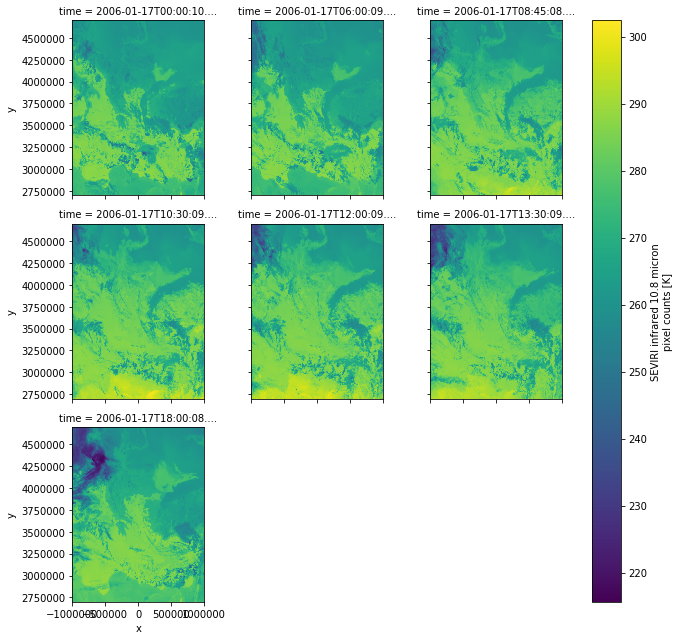

In [7]:
blended_scene["IR_108"].plot(x="x", y="y", col="time", col_wrap=3)

## Loading MODIS data

MODIS data can be obtained at the LAADS DAAC (registration required): https://ladsweb.modaps.eosdis.nasa.gov/search/ 

### MOD021KM

The MODIS [MOD021KM](https://ladsweb.modaps.eosdis.nasa.gov/missions-and-measurements/products/MOD021KM) data (Level 1B Calibrated Radiances at 1km resolution) can be read and displayed just like the MSG data using SatPy:

In [163]:
dateien = ["../data/MODIS/MOD021KM.A2006017.0855.006.2014218155904.hdf"]
files = {"modis_l1b" : dateien}

mod02_scn = Scene(filenames=files)
mod02_scn.load(["natural_color"],resolution=1000)
mod02_scn.show("natural_color")

This gives us an image of the swath data in original MODIS projection. 

But where are we? To find that out, we can resample the data to a simple world map:

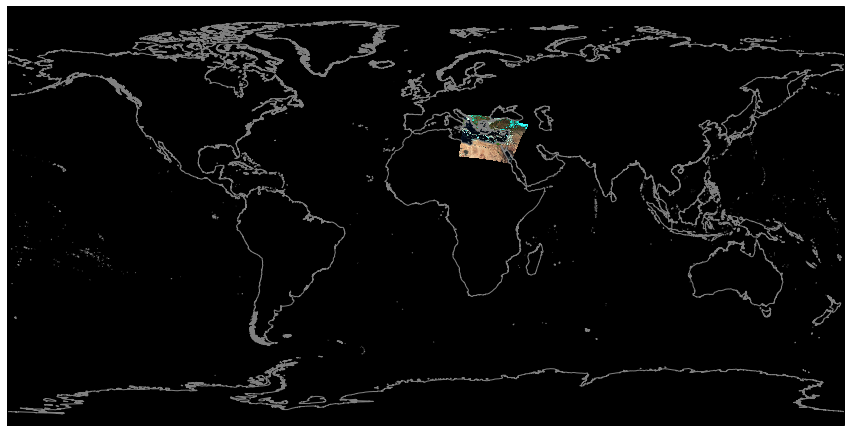

In [6]:
local_scn = mod02_scn.resample("worldeqc30km")

image = np.asarray(local_scn["natural_color"]).transpose(1,2,0)
image = np.interp(image, (np.nanpercentile(image,1), np.nanpercentile(image,99)), (0, 1))

crs = local_scn["natural_color"].attrs["area"].to_cartopy_crs()

fig = plt.subplots(figsize=(15,8))
ax = plt.axes(projection=crs)
ax.coastlines(resolution="10m",color="grey")
ax.imshow(image, transform=crs, extent=crs.bounds, origin="upper")
plt.show()

As MODIS has a very wide aperture angle, the resolution towards the scan margins drops considerably and we can see a lot of distortion at the left and right image borders of the original swath data.

Most often, however, you will want to reproject MODIS data to another projection that is suitable for the covered domain.

This can be done exactly like with the MSG data. So lets resample our MODIS scene to the Greece domain that we defined above:

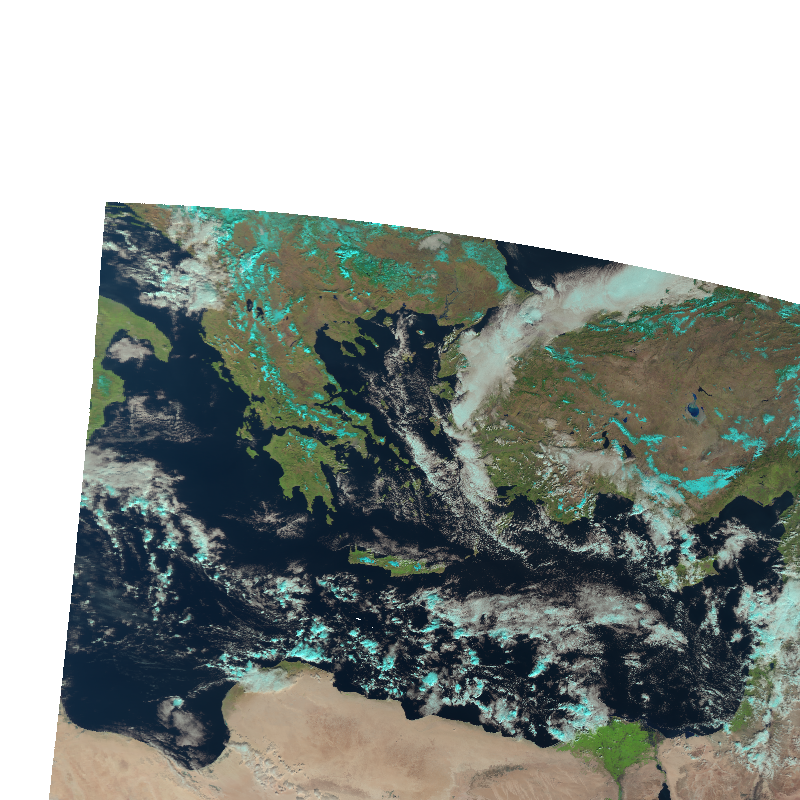

In [7]:
local_scn = mod02_scn.resample(area_def_greece)
local_scn.show("natural_color")

#### Stack swath data

Well ok, that only covers parts of the domain. To better fill the domain, we have to load multiple swath sections.

For this, again, we can use the MultiScene object:

/home/sebastian/miniconda3/envs/python_kurs/lib/python3.7/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in log
  return func(*args2)


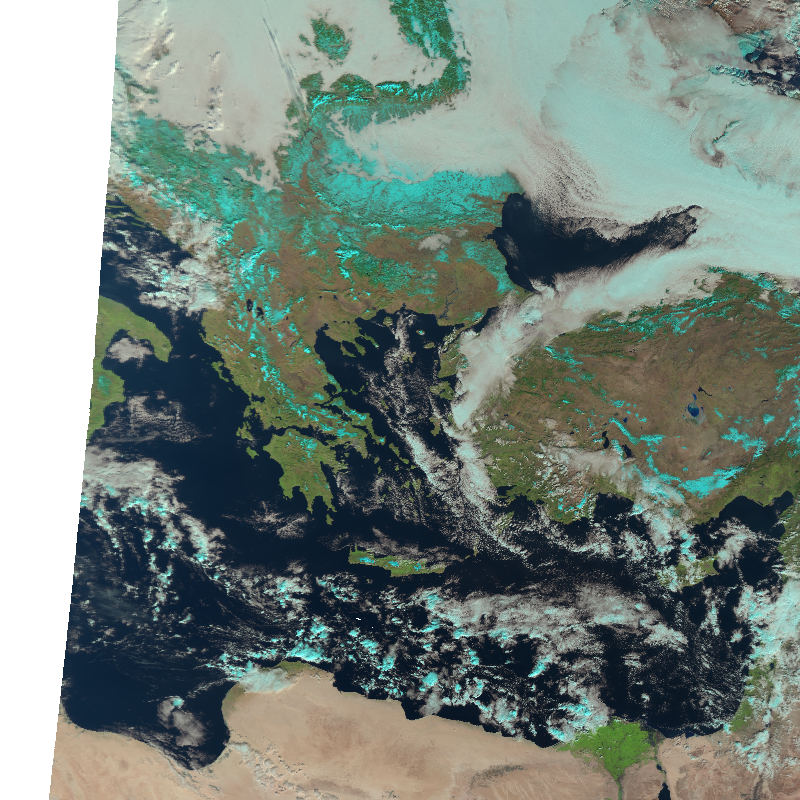

In [11]:
scenes = [
    Scene(reader='modis_l1b', filenames=["../data/MODIS/MOD021KM.A2006017.0855.006.2014218155904.hdf"]),
    Scene(reader='modis_l1b', filenames=["../data/MODIS/MOD021KM.A2006017.0850.006.2014218155843.hdf"])
    ]

mscn = MultiScene(scenes)
mscn.load(['natural_color'],resolution=1000)
mscn_res = mscn.resample(area_def_greece)
blended_scene = mscn_res.blend()
blended_scene.show("natural_color")

And again, with some tweaking, we can also add additional information to the image using CartoPy:

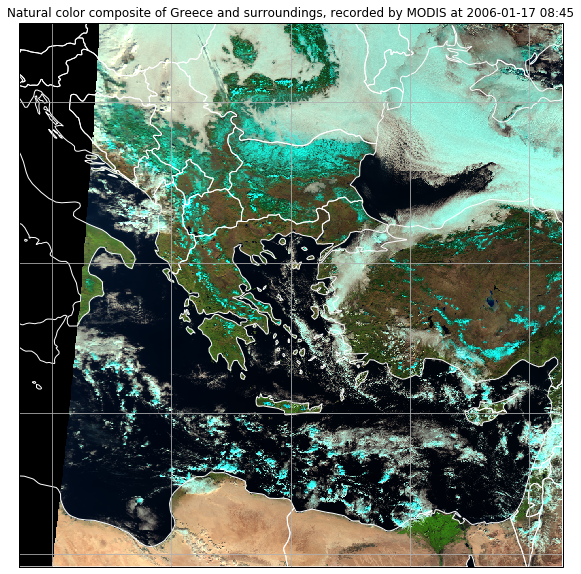

In [14]:
image = np.asarray(blended_scene["natural_color"]).transpose(1,2,0)
image = np.interp(image, (np.nanpercentile(image,1), np.nanpercentile(image,99)), (0, 1))
crs = blended_scene["natural_color"].attrs["area"].to_cartopy_crs()
fig = plt.subplots(figsize=(10,10))
ax = plt.axes(projection=crs)
ax.gridlines(xlocs=range(10,45,5),ylocs=range(25,55,5))
states_provinces = cfeature.NaturalEarthFeature(
    category="cultural",
    name="admin_0_countries",
    scale="50m",
    facecolor="none")
ax.add_feature(states_provinces, edgecolor="white")
ax.imshow(image, transform=crs, extent=crs.bounds, origin="upper")
plt.title("Natural color composite of Greece and surroundings, recorded by MODIS at " + local_scn.attrs["start_time"].strftime("%Y-%m-%d %H:%M"))
plt.show()

##### **Task**

1. Download and read the MOD021KM data at: https://box.uni-marburg.de/index.php/s/9079aAAbGRYWurA
2. Plot the natural color composite in the Algeria domain that you defined before.

**Solution**

2. ```python
mod02_scn = Scene({"modis_l1b" : ["path/to/MODIS-data.hdf"]})
mod02_scn.load(["natural_color"],resolution=1000)
local_scn = mod02_scn.resample(area_def_algeria)
local_scn.show("natural_color")
```

### MOD06_L2

Currently, [MOD06_L2 data](https://modis-images.gsfc.nasa.gov/MOD06_L2/index.html) cannot be read by SatPy. Fortunately, we can circumvent this problem and use xarray directly. 

So, let's open an example data set:

In [10]:
import xarray as xr
modis_l2 = xr.open_dataset("../data/MODIS/MOD06_L2.A2006017.0855.061.2017271194536.hdf")

That's it. There are many data arrays within this data set that you can list with the `data_vars` attribute. But let's only plot the cloud fraction:

In [ ]:
modis_l2["Cloud_Fraction"].plot.imshow(origin="upper")

##### **Task**

1. Download and read the MOD06_L2 data at: https://box.uni-marburg.de/index.php/s/MXrVcvOj9AoFESz
2. Find out the start and end times of the scan.
3. Plot the cloud optical thickness data set

1. ```python
modis_l2 = xr.open_dataset("../path/to/dataset.hdf")
```
2. ```python 
modis_l2.Scan_Start_Time[0,0].values
modis_l2.Scan_Start_Time[-1,-1].values
```
3. ```python
modis_l2["Cloud_Optical_Thickness"].plot.imshow(origin="upper")
```

Ok, looks like it worked. To resample the data, we now have to use the lat/lon bands that come with the MOD06_L2 data set, create a [Swath](https://pyresample.readthedocs.io/en/latest/geo_def.html#swathdefinition) object and use that as area definition in a self-made SatPy Scene object:

In [159]:
from datetime import datetime

# we need to rename dimensions to x,y because satpy expects names to be that way
new_dim_names = {"Cell_Along_Swath_5km:mod06": "y", "Cell_Across_Swath_5km:mod06": "x"}
modis_l2 = modis_l2.rename(new_dim_names)

# For now, we only want to take a look at the cloud fraction
data = modis_l2["Cloud_Fraction"]

# optionally similar to information found in the mod021km we can assign some more informational attributes
data.attrs["coordinates"] = ("longitude", "latitude")
data.attrs["resolution"] = 5000

# set the start time of the scan (we need it for plotting later)
# since xarray create a np.datetime datatype we convert it back to a datetime.datetime object which
# Satpy understands (important for saving).
st = modis_l2.Scan_Start_Time[0,0].values
data.attrs["start_time"] = datetime.utcfromtimestamp((st - np.datetime64("1970-01-01T00:00:00")) / np.timedelta64(1, "s"))

# create a swath area from lon/lats
lons = modis_l2["Longitude"]
lats = modis_l2["Latitude"]
swath = geometry.SwathDefinition(lons,lats)

# and assign the SwathDefinition to the area attribute of the data array
data.attrs["area"] = swath

# init an empty satpy Scene
mod06_scn = Scene()

# assign a new Scene dataset
mod06_scn["cloud_fraction"] = data

Now that we have generated a SatPy Scene object, we can use all its functionality, e.g. resampling:

In [ ]:
mod06_scn_res = mod06_scn.resample(area_def_greece, resampler="nearest", radius_of_influence=10000)

mod06_scn_res.show("cloud_fraction")

And then we can plot it as usual:

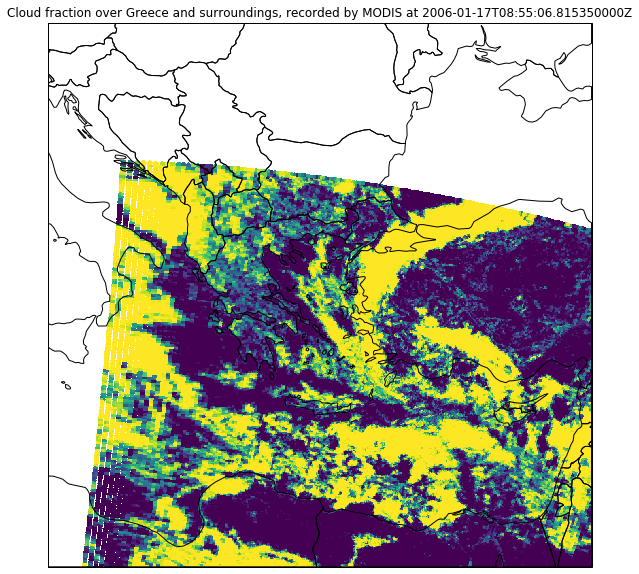

In [30]:
crs = mod06_scn_res["cloud_fraction"].attrs["area"].to_cartopy_crs()

fig = plt.subplots(figsize=(10,10))
ax = plt.axes(projection=crs)
#ax.gridlines(xlocs=range(-15,30,5),ylocs=range(15,47,5))
states_provinces = cfeature.NaturalEarthFeature(
    category="cultural",
    name="admin_0_countries",
    scale="50m",
    facecolor="none")
ax.add_feature(states_provinces, edgecolor="black")
ax.imshow(mod06_scn_res["cloud_fraction"], transform=crs, extent=crs.bounds, origin="upper")
plt.title("Cloud fraction over Greece and surroundings, recorded by MODIS at " + np.datetime_as_string(mod06_scn_res.attrs["start_time"], timezone='UTC'))
plt.show()

## Band calculations

As SatPy's Scene class internally uses the xarray data structure to store its data sets, you can do various calculations on these bands with ease.

Often, you will need the difference valus of two bands, which help to highlight certain atmospheric features. For example, the difference values between the bands at 10.8μm and 3.9μm help to distinguish low stratus layers from higher clouds at night.

So, let's first load the MSG scene at 00:00 UTC on 17. January 2006 and resample it to the area of Greece again:

In [3]:
dateien = ["../data/W_XX-EUMETSAT-Darmstadt,VIS+IR+HRV+IMAGERY,MSG1+SEVIRI_C_EUMG_20060117000010.nc"]
files = {"seviri_l1b_nc" : dateien}

scn = Scene(filenames=files)
scn.load(scn.all_dataset_names()[1:])

local_scn = scn.resample(area_def_greece)

We can now calculate the difference values by simply subtracting the bands from each other with the `-` operator and we can store them in a new data set within the Scene object:

In [4]:
local_scn["band_diff"] = local_scn["IR_108"]-local_scn["IR_039"]

Let's see what we got:

/home/sebastian/miniconda3/envs/python_kurs/lib/python3.7/site-packages/dask/core.py:119: RuntimeWarning: divide by zero encountered in true_divide
  return func(*args2)


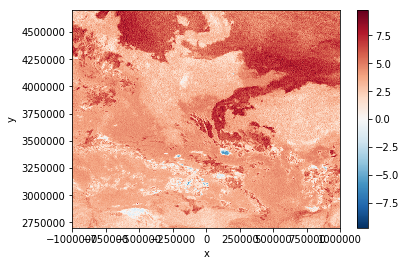

In [5]:
local_scn["band_diff"].plot.imshow()

High difference values indicate low stratus clouds. This means, the dark-red regions in the plot above are covered by low stratus.

By applying a threshold value (~5K), we can generate a low stratus cloud mask for our current scene:

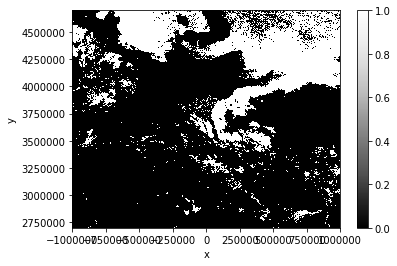

In [6]:
local_scn["stratus_mask"] = local_scn["band_diff"] > 5
local_scn["stratus_mask"].plot.imshow(cmap="Greys_r")

## Exercise 7

- Complete the seventh assignment and push your results until tuesday 14:00 next week
- Assignment link: [https://classroom.github.com/a/NcI1MPY4](https://classroom.github.com/a/NcI1MPY4)

############################################
# Ab hier nur code snippets und testing
############################################

 Notes

- links zu "einfachen" informationen zu Wolken tests
    - https://www.intechopen.com/books/advances-in-geoscience-and-remote-sensing/automated-detection-of-clouds-in-satellite-imagery
    - https://www.cfa.harvard.edu/~xliu/res/CloudRetrieval.htm
    - Modis tests ab seite 14: https://modis-atmosphere.gsfc.nasa.gov/sites/default/files/ModAtmo/MOD35_ATBD_Collection6_1.pdf

def satpy_scn_from_xr(file_or_xr, mod03_file_or_xr=None, variables=None, verbose=True):
    """Creates a satpy Scene from a non supported MODIS product
    
    Will try to create a Satpy Scene with all variables as specified
    in the parameters.
    
    Parameters
    ----------
    file_or_xr : xr.Dataset or pathlib.Path or str
        Either a filename or an xr.Dataset can be given.
        If filename data will be read using `xr.open_dataset()`.
    mod03_file_or_xr : xr.Dataset or pathlib.Path or str, optional
        Either a filename or an xr.Dataset of mod03 geolocations can be given.
        If filename data will be read using `xr.open_dataset()`.
    variables : list of string, optional
        Names of the variable in the MODIS file which to put in the Scene.
        If None all v variables in file are returned.
    
    Returns
    -------
    satpy.Scene
    
    """
    from pathlib import Path
    from satpy import Scene
    import xarray as xr
    from pyresample import geometry
    from datetime import datetime
    
    if (isinstance(file_or_xr, Path) or isinstance(file_or_xr, str)):
        modis_l2 = xr.open_dataset(file_or_xr)
    else:
        modis_l2 = file_or_xr
        
    if variables is None:
        variables = list(modis_l2.data_vars.keys())
        variables = [v for v in variables if v not in ["Latitude", "Longitude"]]
    
    if mod03_file_or_xr is not None:
        if (isinstance(mod03_file_or_xr, Path) or isinstance(mod03_file_or_xr, str)):
            mod03= xr.open_dataset(mod03_file_or_xr, drop_variables="Scan Type")
        else:
            mod03 = mod03_file_or_xr
        
        mod03_new_dim_names = {"nscans*10:MODIS_Swath_Type_GEO": "y", "mframes:MODIS_Swath_Type_GEO": "x"}
        mod03 = mod03.rename(mod03_new_dim_names)
        
        lons1km = mod03["Longitude"]
        lats1km = mod03["Latitude"]
        swath_def_1km = geometry.SwathDefinition(lons1km, lats1km)
    
    new_dim_names = {"Cell_Along_Swath_5km:mod06": "y", "Cell_Across_Swath_5km:mod06": "x"}
    
    lons5km = modis_l2["Longitude"]
    lats5km = modis_l2["Latitude"]
    lons5km = lons5km.rename(new_dim_names)
    lats5km = lats5km.rename(new_dim_names)
    swath_def_5km = geometry.SwathDefinition(lons5km, lats5km)
        
    #init Scene
    out_scn = Scene()
    #create a Scene dataset for every variable
    for v in variables:
        ds = modis_l2[v]
        ds.attrs["name"] = v
        st = modis_l2.Scan_Start_Time[0,0].values
        ds.attrs["start_time"] = datetime.utcfromtimestamp((st - np.datetime64('1970-01-01T00:00:00'))
                     / np.timedelta64(1, 's'))
        ds.attrs["coordinates"] = ("longitude", "latitude")
        if lons5km.shape == ds.shape:
            ds = ds.rename(new_dim_names)
            ds.attrs["area"] = swath_def_5km
            ds.attrs["resolution"] = 5000
            out_scn[v] = ds
        elif ((mod03_file_or_xr is not None) and (lons1km.shape == ds.shape)):
            new_dim_names = {"Cell_Along_Swath_1km:mod06": "y", "Cell_Across_Swath_1km:mod06": "x"}
            ds = ds.rename(new_dim_names)
            ds.attrs["area"] = swath_def_1km
            ds.attrs["resolution"] = 1000
            out_scn[v] = ds
        else:
            if verbose:
                print("The resolution of the lat/lon does not match the shape\n \
                of the data of variable {0}. Therefore variable {0} was skipped.\n \
                Try with handing a mod03 file to the mod03_file_or_xr parameter.".format(v))

    return out_scn

import numpy as np
#scn = satpy_scn_from_xr("../data/MODIS/MOD06_L2.A2006017.0855.061.2017271194536.hdf", "../data/MODIS/MOD03.A2006017.0855.061.2017258190054.hdf"  )#, variables=["Cloud_Fraction", "Surface_Pressure"])
scn = satpy_scn_from_xr("../data/MODIS/MOD06_L2.A2006017.1210.006.2014353173750.hdf", "../data/MODIS/MOD03.A2006017.1210.006.2012262224035.hdf", variables=["Cloud_Optical_Thickness"]  )#, variables=["Cloud_Fraction", "Surface_Pressure"])

from pyproj import Proj, transform
#get min/max of lon(lats)
lons = scn["Cloud_Optical_Thickness"].area.lons
lats = scn["Cloud_Optical_Thickness"].area.lats
lonmin = np.min(lons)
lonmax = np.max(lons)
latmin = np.min(lats)
latmax = np.max(lats)

#calculate center between min/max of lon/lat
lon_center = lonmin + (lonmax - lonmin)/2
lat_center = latmin + (latmax - latmin)/2
print(lon_center, lat_center)
print(lonmin, latmin, lonmax, latmax)

#create proj4 string with center points
p2 = Proj("+proj=laea +lat_0={0} +lon_0={1}".format(lat_center.values, lon_center.values))

#margin to add to  area extent
margin = 1.5
#create area extent in projection coordinates
llx, lly = p2(lonmin - margin, latmin - margin)
urx, ury = p2(lonmax + margin, latmax + margin)
print(llx, lly, urx, ury)

#calculate width/height in pixels for given resolution in meters
res = 1000
w = np.round((urx - llx) / res)
h = np.round((ury - lly) / res)

#create pyresample area definition
area_id = "NorthEastAtlantic"
description = "North East Atlantic in Lambert Azimuthal Equal Area projection"
proj_id = "NorthEastAtlantic"
proj_dict = {"proj": "laea", "lat_0": lat_center, "lon_0": lon_center}
width = w
height = h

area_extent = (llx, lly, urx, ury)
area_def_NEA = geometry.AreaDefinition(area_id, proj_id, description, proj_dict, width, height, area_extent)

#scn_res = scn.resample(area_def_NEA, resampler="nearest", radius_of_influence=10000)
from pyresample.utils import load_area
eur = load_area("/home/ro/dev/phd/hyfog/hyfog/data/areas.yaml", "LCRS_MSG_eur_ex")
scn_res = scn.resample(area_def_NEA, resampler="nearest", radius_of_influence=2000)
scn_res.show("Cloud_Optical_Thickness")

scn.save_datasets(writer="geotiff",
                  datasets=["Cloud_Optical_Thickness"],
                  filename="{name}_{start_time:%Y%m%d_%H%M%S}.tif",
                  #filename="{name}.tif",
                  base_dir="/home/ro", enhance=False, dtype=np.float32)